In [1]:
struct Delivery
    x::Float64
    y::Float64
end;
function random_delivery()
    x = rand(0.0:0.1:100.0)
    y = rand(0.0:0.1:100.0)
    return Delivery(x, y)
end;
random_delivery()

Delivery(22.8, 69.9)

In [2]:
struct TSProblem
    deliveries::Array{Delivery}
end;

function random_instance(n_deliveries)
    deliveries = [random_delivery() for _=1:n_deliveries]
    problem = TSProblem(deliveries)
    return problem
end;
random_instance(5)

TSProblem(Delivery[Delivery(9.6, 95.9), Delivery(77.1, 3.6), Delivery(69.3, 69.0), Delivery(97.0, 31.5), Delivery(21.1, 66.2)])

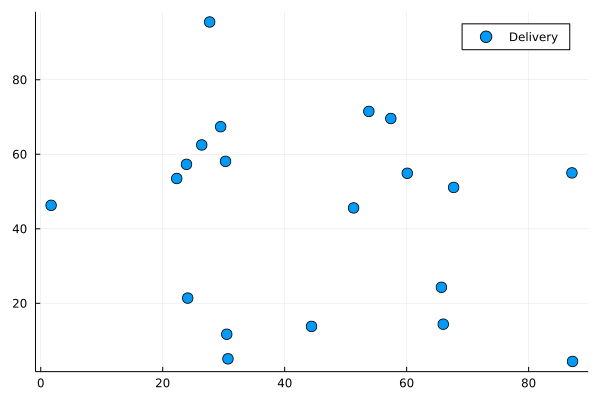

In [3]:
using Plots

function display_problem(problem)
    x_pos = [c.x for c in problem.deliveries]
    y_pos = [c.y for c in problem.deliveries]
    return scatter(x_pos, y_pos, shape = :circle, markersize = 6, label= "Delivery")
end;

problem = random_instance(20)
display_problem(problem)

![problem](problem.png)

In [4]:
function dist(del1::Delivery, del2::Delivery)
    return sqrt((del1.x - del2.x)^2 + (del1.y - del2.y)^2)
end
function calc_travelmatrix(deliveries::Array{Delivery})
    tm = zeros(Float64, length(deliveries), length(deliveries))
    for i = 1:length(deliveries)
        for j = 1:length(deliveries)
            tm[i, j] = dist(deliveries[i], deliveries[j])
        end
    end
    return tm
end
travelmatrix = calc_travelmatrix(problem.deliveries)

20×20 Matrix{Float64}:
   0.0     39.4069   108.809   33.0256   …  35.4572   28.1576   80.7059
  39.4069   0.0       71.6874  31.8027       4.07063  27.9866   46.0541
 108.809   71.6874     0.0     84.0967      74.9531   85.43     29.2961
  33.0256  31.8027    84.0967   0.0         28.8402    5.79828  54.8063
  37.4903  29.4391    78.2387   5.87963     27.052     9.33435  48.9449
  55.6475  60.377     95.2148  29.5386   …  57.8744   34.9006   67.6757
  89.6889  55.8659    23.4401  62.3039      58.3888   64.3525    9.90454
  71.893   33.0946    50.6001  61.1616      37.1637   58.9196   37.4226
  83.8468  63.8437    57.168   50.9652      64.1789   55.709    37.3872
  42.3457  38.6163    81.3807   9.88989     36.2802   15.6541   52.3087
  55.1994  24.7631    54.6466  30.0935   …  26.0204   30.8299   25.7109
  59.7609  21.174     50.6077  42.8445      24.6854   41.5323   26.8745
  74.1874  58.5844    65.3499  41.1643      58.2417   46.3159   41.701
  83.3893  57.2943    43.8201  51.92     

In [5]:
using JuMP
import GLPK

model = Model(GLPK.Optimizer)
# route is an adjence matrix representing a route traveled
route=@variable(model, route[1:length(problem.deliveries), 1:length(problem.deliveries)], Bin)
# mtzu is a helper variable to ensure no subtours are allowed (only one continous tour)
# see MTZ constraint
mtzu = @variable(model, mtzu[1:length(problem.deliveries)], Int)

# ensure all events are planned
@constraint(model, [i = 1:length(problem.deliveries)], sum(route[i, :]) == 1.0)
# ensure there is just one route
@constraint(model, [c = 1:length(problem.deliveries)], sum(route[:, c]) == 1.0)
# disallow traveling to itself
@constraint(model, [j = 1:length(problem.deliveries)], route[j, j] == 0)

# MTZ constraints for removing subtours
n = length(problem.deliveries)
@constraint(model, [ui = 1:n, uj = 2:n], mtzu[ui] + route[ui, uj] <= mtzu[uj]+ (n - 1) * (1 - route[ui, uj]) )

traveltime = travelmatrix.* route 
@objective(model, Min, sum(traveltime))
optimize!(model)
@show termination_status(model)
@show primal_status(model)
@show dual_status(model)
@show objective_value(model)
@show value.(route)

termination_status(model) = MathOptInterface.OPTIMAL
primal_status(model) = MathOptInterface.FEASIBLE_POINT
dual_status(model) = MathOptInterface.NO_SOLUTION
objective_value(model) = 352.23158274970643
value.(route) = [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

20×20 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

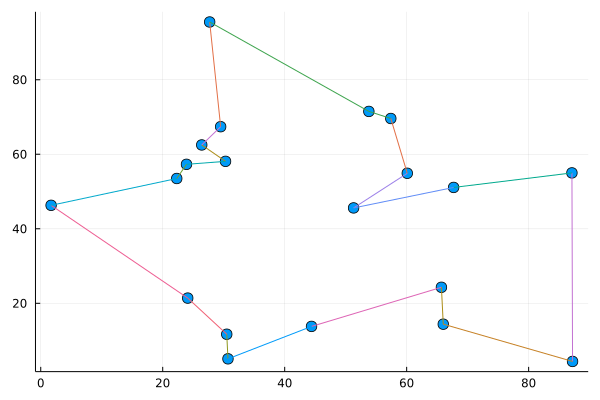

In [6]:
function display_solution(problem, route)
    x_pos = [c.x for c in problem.deliveries]
    y_pos = [c.y for c in problem.deliveries]
    plot_result = scatter(x_pos, y_pos, shape = :circle, markersize = 6)
    for i in 1:length(problem.deliveries)
        for j in 1:length(problem.deliveries)
            val = route[i, j]
            if val > 0
                del1 = problem.deliveries[i]
                del2 = problem.deliveries[j]
                plot!([del1.x, del2.x], [del1.y, del2.y], legend = false)
            end
        end
    end
    return plot_result
end;
display_solution(problem, value.(route))